# Analysis of full demolition permits by the City of Austin

- This analysis starts with a file that has been downloaded and processed in another notebook, `01_Download_Process.ipynb`.

## Set up and configurations

In [58]:
import pandas as pd
import numpy as np
import altair as alt

## Import file

In [62]:
# Column type fixes
column_types = {
    "ApplicantPhone": pd.np.str,
    "ContractorPhone": pd.np.str,
    'CalendarYearIssued': pd.np.str,
}

# import raw data
data_raw = pd.read_csv(
    '../data-processed/residential_demolitions.csv',
    index_col=None,
    dtype=column_types
)

demolitions = data_raw
demolitions.shape

(3169, 67)

## How the number of demolition permits have changed over time

How many demolition permits have been been issued in past years.

### Permits per year

In [63]:
# create data from of permits by year
demos_by_year = demolitions.CalendarYearIssued.value_counts().reset_index()
demos_by_year.columns = ['Year', 'Count']
demos_by_year.sort_values('Year')

,Year,Count
10,2008,110
9,2009,137
8,2010,152
7,2011,176
6,2012,263
4,2013,328
2,2014,357
3,2015,344
1,2016,457
0,2017,567


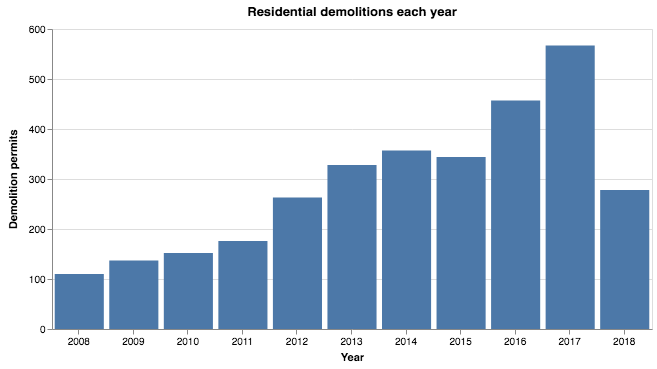

In [64]:
# make chart
alt.Chart(demos_by_year.reset_index(), title="Residential demolitions each year").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

### Permits in first half of year

If we want to see how permits are going for 2018, we need to look at the first six months of each year and compare them.

In [65]:
# List to filter for first six months from text string
six_months_list = ['01', '02', '03', '04', '05', '06']

# Make df of first half year permits
# Based on splitting string of date and making sure
# that string is in the list above.
# (another way might be to convert to a date and us `.month`)
six_months_filtered = demolitions[demolitions.IssuedDate.str[5:7].isin(six_months_list)]
six_months_filtered.shape

(1659, 67)

In [66]:
six_months_data = six_months_filtered.CalendarYearIssued.value_counts().reset_index()
six_months_data.columns = ['Year', 'Count']
six_months_data

,Year,Count
0,2017,307
1,2018,278
2,2014,176
3,2013,167
4,2016,161
5,2015,150
6,2012,132
7,2011,84
8,2010,75
9,2009,68


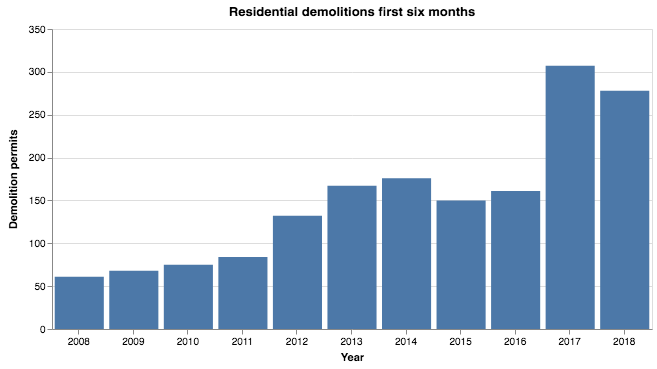

In [67]:
# make chart
alt.Chart(six_months_data.reset_index(), title="Residential demolitions first six months").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

## References

In [68]:
demolitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 67 columns):
Unnamed: 0                    3169 non-null int64
PermitType                    3169 non-null object
PermitTypeDesc                3169 non-null object
PermitNum                     3169 non-null object
PermitClassMapped             3169 non-null object
PermitClass                   3169 non-null object
WorkClass                     3169 non-null object
Condominium                   3169 non-null object
ProjectName                   3169 non-null object
Description                   3169 non-null object
TCAD_ID                       3155 non-null object
PropertyLegalDescription      2748 non-null object
AppliedDate                   3169 non-null object
IssuedDate                    3169 non-null object
DayIssued                     3169 non-null object
CalendarYearIssued            3169 non-null object
FiscalYearIssued              3169 non-null int64
IssuedInLast30Days          